# SVM and Random Forrest application

## Imports and Data Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import make_pipeline

### Creation of reused functions

In [ ]:
def split_to_submodel_unput(X_features, y):
  # Get male data only
  odd_indices = np.where(y % 2 != 0)[0]
  X_features_male = X_features[odd_indices, :]
  y_male = y[odd_indices]

  # Get female data only
  even_indices = np.where(y % 2 == 0)[0]
  X_features_female = X_features[even_indices, :]
  y_female = y[even_indices]

  # Replace odd numbers with 1 and even numbers with 0 to get gendered data
  y_gender = np.where(y % 2 == 0, 0, 1)

  return X_features_male, y_male, X_features_female, y_female, y_gender

In [ ]:
def get_SVM_preds(X_val,svm_gender,svm_female_age,svm_male_age):
    # Generate gender predictions on dataset BASE
    predicted_gender = svm_gender.predict(X_val)

    # Based on gender prediction apply age cohort prediction
    predicted_age = []
    for i, gender in enumerate(predicted_gender):
        if gender == 0: # female
            predicted_age.append(svm_female_age.predict(X_val[i].reshape(1, -1))[0])
        elif gender == 1: # male
            predicted_age.append(svm_male_age.predict(X_val[i].reshape(1, -1))[0])
    predicted_age = np.array(predicted_age)
    
    return predicted_gender, predicted_age

In [ ]:
def confusion_matrix_show(y_val_gender, predicted_gender):
    # Confustion matrix for BASE

    # Assuming y_true and y_pred contain the true and predicted labels respectively
    cm = confusion_matrix(y_val_gender, predicted_gender)

    # Create a heatmap visualization of the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def mapping_tool(df):
    # Define the mapping dictionary
    mapping = {
        0: '15_19_F', 1: '15_19_M', 2: '20_24_F', 3: '20_24_M', 4: '25_29_F', 5: '25_29_M',
        6: '30_34_F', 7: '30_34_M', 8: '35_39_F', 9: '35_39_M', 10: '40_44_F', 11: '40_44_M',
        12: '45_49_F', 13: '45_49_M', 14: '50_54_F', 15: '50_54_M', 16: '55_59_F', 17: '55_59_M',
        18: '60_64_F', 19: '60_64_M', 20: '65_69_F', 21: '65_69_M', 22: '70_74_F', 23: '70_74_M',
        24: '75_79_F', 25: '75_79_M', 26: '80_84_F', 27: '80_84_M', 28: '85_89_F', 29: '85_89_M'
    }

    # Map the values using the mapping dictionary
    df['True'] = df['True'].map(mapping)
    df['Predicted'] = df['Predicted'].map(mapping)
    
    return df

In [ ]:
def graph_heat(df):
  # Calculate the frequency of each point
  point_frequency = df.groupby(['True', 'Predicted']).size().reset_index(name='Frequency')

  # Create a pivot table to reshape the data for the heatmap
  heatmap_data = point_frequency.pivot('Predicted', 'True', 'Frequency')

  # Set up the heatmap figure
  fig, ax = plt.subplots(figsize=(20, 10))

  # Invert the 'Predicted' axis in the heatmap data
  heatmap_data = heatmap_data.iloc[::-1]

  # Create the heatmap
  sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, cbar=True, ax=ax, fmt='.0f')

  # Add labels and title
  plt.xlabel('True Age Cohort and Gender')
  plt.ylabel('Predicted Age Cohort and Gender')
  plt.title('Heatmap based on Frequency')

  # Show the plot
  plt.show()

### Creating datasets

#### Baseline PCA dataset

In [ ]:
# Upload the features and lab
X_features_pca = np.load('/X_pca_core.npy')
y = np.load('/y_core.npy')

In [ ]:
# Convert to an array of class indices
y = np.argmax(y, axis=1)

In [ ]:
# Split data into train test - for validating data
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_features_pca, y, test_size=0.2, shuffle=True)

In [ ]:
# Get the different model training inputs
X_train_male_pca, y_train_male_pca, X_train_female_pca, y_train_female_pca, y_train_gender_pca = split_to_submodel_unput(X_train_pca, y_train_pca)
X_val_male_pca, y_val_male_pca, X_val_female_pca, y_val_female_pca, y_val_gender_pca = split_to_submodel_unput(X_val_pca, y_val_pca)

#### CNN based dataset

In [ ]:
# Upload the features and lab
X_features = np.load('/X_CNN_features_core.npy')
y = np.load('/y_core.npy')

In [ ]:
# Convert to an array of class indices
y = np.argmax(y, axis=1)

In [ ]:
# Split data into train test - for validating data
X_train, X_val, y_train, y_val = train_test_split(X_features, y, test_size=0.2, shuffle=True)

In [ ]:
# Get the different model training inputs
X_train_male, y_train_male, X_train_female, y_train_female, y_train_gender = split_to_submodel_unput(X_train, y_train)
X_val_male, y_val_male, X_val_female, y_val_female, y_val_gender = split_to_submodel_unput(X_val, y_val)

#### Resampled CNN dataset

In [ ]:
# Create the resampling pipeline
resampling_pipeline = make_pipeline(
    SMOTE(),           # Oversample the minority class using SMOTE
    NearMiss(),        # Undersample the majority class using NearMiss
    RandomUnderSampler(),  # Further undersample the majority class using RandomUnderSampler
    ADASYN()           # Oversample the minority class using ADASYN
)

# Apply resampling to your training data
X_train_re, y_train_re = resampling_pipeline.fit_resample(X_train, y_train)

X_train_male_re, y_train_male_re, X_train_female_re, y_train_female_re, y_train_gender_re = split_to_submodel_unput(X_train_re, y_train_re)

#### Cross validation CNN dataset

In [ ]:
# Load cross validation dataset
X_val_cross = np.load('/X_CNN_features_cross.npy')
y_val_cross = np.load('/y_cross.npy')
y_val_cross = np.argmax(y_val_cross, axis=1)
y_val_gender_cross = np.where(y_val_cross % 2 == 0, 0, 1)

## SVM Classifier

### Training the classifiers

#### Baseline classifier

In [ ]:
# Fit basline full model
svm_full_pca = svm.SVC()
svm_full_pca.fit(X_train_pca, y_train_pca)

# Fit baseline gender model
svm_gender_pca = svm.SVC()
svm_gender_pca.fit(X_train_pca, y_train_gender_pca)

# Fit baseline male age model
svm_male_age_pca = svm.SVC()
svm_male_age_pca.fit(X_train_male_pca, y_train_male_pca)

# Fit baseline female age model
svm_female_age_pca = svm.SVC()
svm_female_age_pca.fit(X_train_female_pca, y_train_female_pca)

SVC()

#### Base classifier

In [ ]:
# Fit full model
svm_full = svm.SVC(C=1, gamma=0.01)
svm_full.fit(X_train, y_train)

# Fit gender model
svm_gender = svm.SVC(C=1, gamma=0.01)
svm_gender.fit(X_train, y_train_gender)

# Fit male age model
svm_male_age = svm.SVC(C=1, gamma=0.01)
svm_male_age.fit(X_train_male, y_train_male)

# Fit female age model
svm_female_age = svm.SVC(C=1, gamma=0.01)
svm_female_age.fit(X_train_female, y_train_female)

SVC(C=1, gamma=0.01)

#### Classifier with Resampling

In [ ]:
# Fit full model
svm_full_re = svm.SVC(C=1, gamma=0.01)
svm_full_re.fit(X_train_re, y_train_re)

# Fit gender model
svm_gender_re = svm.SVC(C=1, gamma=0.01)
svm_gender_re.fit(X_train_re, y_train_gender_re)

# Fit male age model
svm_male_age_re = svm.SVC(C=1, gamma=0.01)
svm_male_age_re.fit(X_train_male_re, y_train_male_re)

# Fit female age model
svm_female_age_re = svm.SVC(C=1, gamma=0.01)
svm_female_age_re.fit(X_train_female_re, y_train_female_re)

SVC(C=1, gamma=0.01)

### Generating predictions

#### Baseline model training

In [ ]:
# Generate predictions on dataset FULL
predicted_age_full_pca = svm_full_pca.predict(X_val_pca)

In [ ]:
# Generate predictions on dataset BASE
predicted_gender_pca, predicted_age_pca = get_SVM_preds(X_val_pca,svm_gender_pca,svm_female_age_pca,svm_male_age_pca)

In [ ]:
# Print classification report FULL
print(classification_report(y_val_pca, predicted_age_full_pca))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.00      0.00      0.00        24
           2       0.32      0.16      0.21       156
           3       0.24      0.19      0.21       117
           4       0.24      0.13      0.17       195
           5       0.29      0.21      0.25       149
           6       0.20      0.29      0.24       248
           7       0.23      0.26      0.24       183
           8       0.20      0.43      0.27       247
           9       0.20      0.36      0.26       193
          10       0.18      0.15      0.16       213
          11       0.17      0.17      0.17       147
          12       0.22      0.09      0.13       181
          13       0.10      0.05      0.07       102
          14       0.16      0.09      0.11       149
          15       0.10      0.04      0.06       121
          16       0.10      0.04      0.06       134
          17       0.08    

C:\Users\Mikolaj Baranski\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mikolaj Baranski\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mikolaj Baranski\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print classification report FULL
print(classification_report(y_val_pca, predicted_age_full_pca))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.00      0.00      0.00        24
           2       0.32      0.16      0.21       156
           3       0.24      0.19      0.21       117
           4       0.24      0.13      0.17       195
           5       0.29      0.21      0.25       149
           6       0.20      0.29      0.24       248
           7       0.23      0.26      0.24       183
           8       0.20      0.43      0.27       247
           9       0.20      0.36      0.26       193
          10       0.18      0.15      0.16       213
          11       0.17      0.17      0.17       147
          12       0.22      0.09      0.13       181
          13       0.10      0.05      0.07       102
          14       0.16      0.09      0.11       149
          15       0.10      0.04      0.06       121
          16       0.10      0.04      0.06       134
          17       0.08    

C:\Users\Mikolaj Baranski\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mikolaj Baranski\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mikolaj Baranski\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


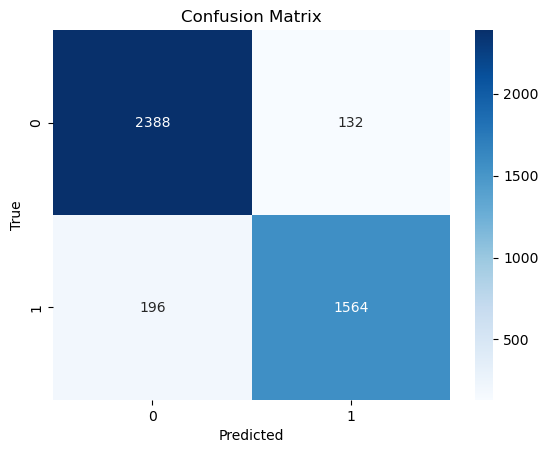

In [ ]:
# Confustion matrix for BASE
confusion_matrix_show(y_val_gender_pca, predicted_gender_pca)

In [ ]:
# Turn the predictions into a dataframe
df_full_pca = pd.DataFrame({'True': y_val_pca, 'Predicted': predicted_age_full_pca})
df_full_pca = mapping_tool(df_full_pca)

df_base_pca = pd.DataFrame({'True': y_val_pca, 'Predicted': predicted_age_pca})
df_base_pca = mapping_tool(df_base_pca)

C:\Users\Mikolaj Baranski\AppData\Local\Temp\ipykernel_8600\1502468780.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = point_frequency.pivot('Predicted', 'True', 'Frequency')


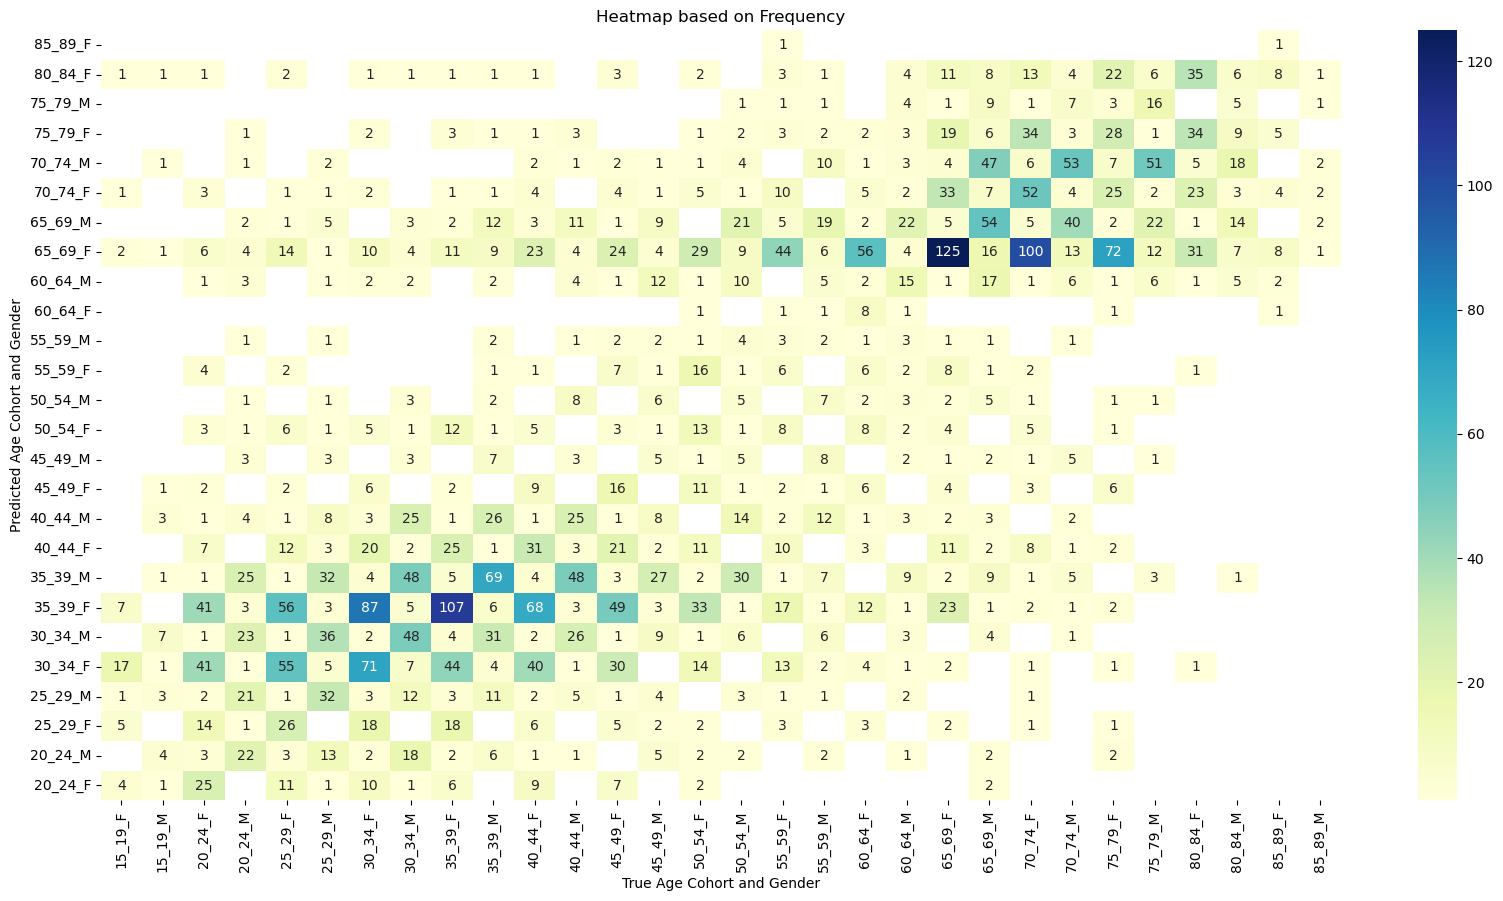

In [ ]:
# Create classification heatmap
graph_heat(df_full_pca)

C:\Users\Mikolaj Baranski\AppData\Local\Temp\ipykernel_8600\1502468780.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = point_frequency.pivot('Predicted', 'True', 'Frequency')


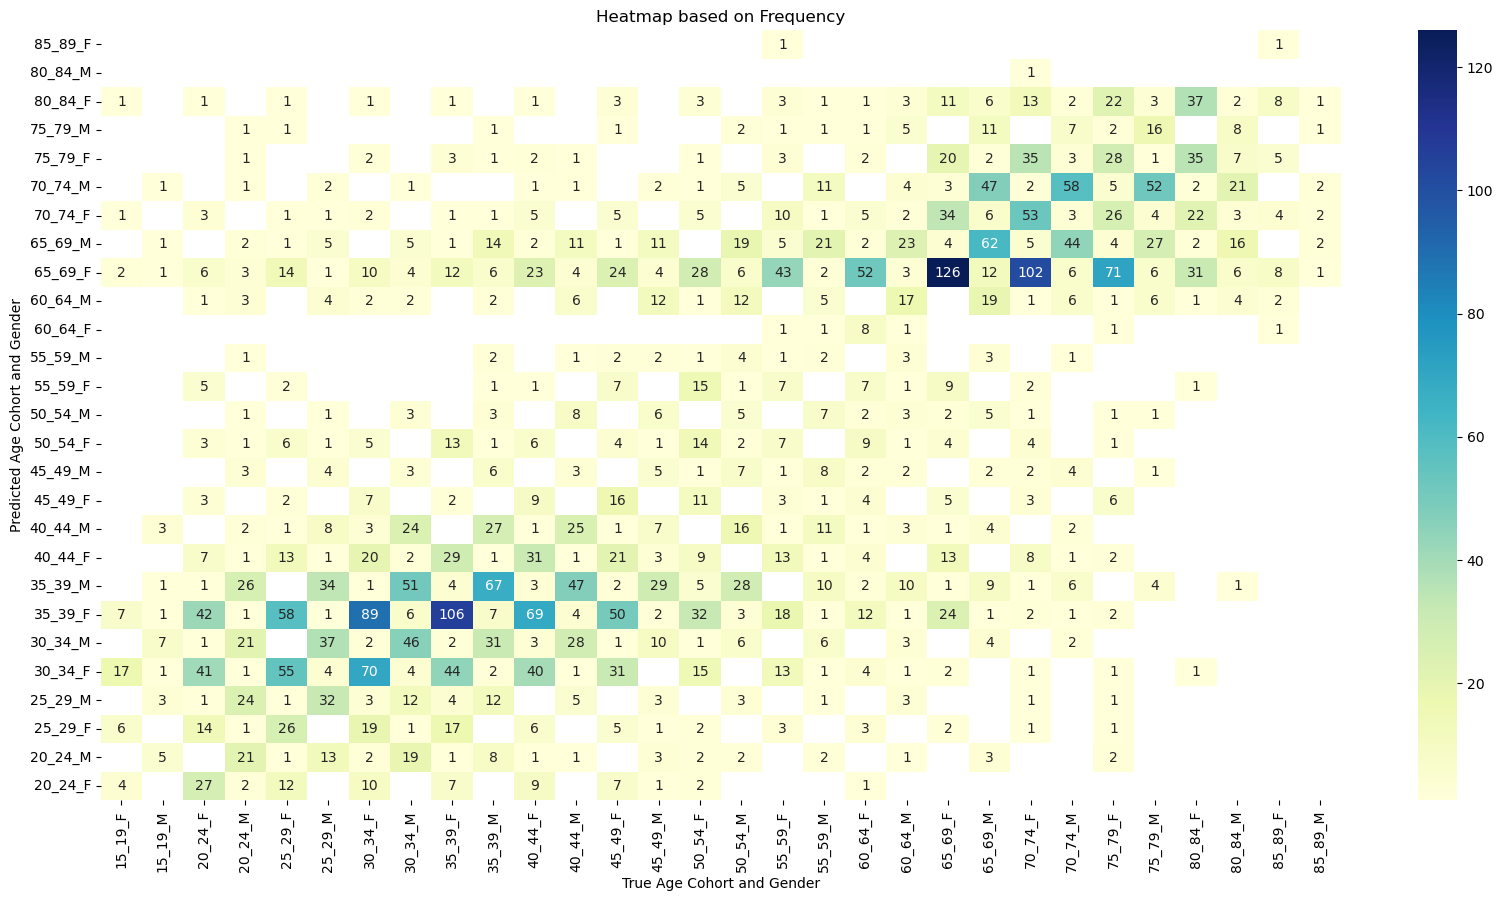

In [ ]:
# Create classification heatmap
graph_heat(df_base_pca)

#### Base training dataset

In [ ]:
# Generate predictions on dataset FULL
predicted_age_full = svm_full.predict(X_val)

In [ ]:
# Generate predictions on dataset BASE
predicted_gender, predicted_age = get_SVM_preds(X_val,svm_gender,svm_female_age,svm_male_age)

In [ ]:
# Generate predictions on dataset FULL
predicted_age_full_re = svm_full_re.predict(X_val)

In [ ]:
# Generate predictions on dataset RESAMPLED
predicted_gender_re, predicted_age_re = get_SVM_preds(X_val,svm_gender_re,svm_female_age_re,svm_male_age_re)

In [ ]:
# Print classification report FULL
print(classification_report(y_val, predicted_age_full))

              precision    recall  f1-score   support

           0       1.00      0.62      0.76        39
           1       1.00      0.59      0.74        29
           2       0.68      0.66      0.67       124
           3       0.82      0.81      0.81       120
           4       0.65      0.63      0.64       202
           5       0.73      0.65      0.69       131
           6       0.51      0.61      0.56       244
           7       0.68      0.72      0.70       171
           8       0.58      0.60      0.59       252
           9       0.65      0.77      0.71       210
          10       0.59      0.56      0.58       234
          11       0.69      0.68      0.68       185
          12       0.66      0.63      0.64       175
          13       0.71      0.71      0.71       107
          14       0.71      0.64      0.67       156
          15       0.74      0.72      0.73       116
          16       0.71      0.64      0.67       127
          17       0.77    

In [ ]:
# Print classification report BASE
print(classification_report(y_val, predicted_age))

              precision    recall  f1-score   support

           0       1.00      0.62      0.76        39
           1       1.00      0.59      0.74        29
           2       0.70      0.66      0.68       124
           3       0.82      0.82      0.82       120
           4       0.64      0.63      0.64       202
           5       0.71      0.65      0.68       131
           6       0.52      0.61      0.56       244
           7       0.69      0.71      0.70       171
           8       0.57      0.60      0.58       252
           9       0.66      0.76      0.71       210
          10       0.60      0.56      0.58       234
          11       0.69      0.68      0.68       185
          12       0.66      0.63      0.64       175
          13       0.71      0.71      0.71       107
          14       0.70      0.64      0.67       156
          15       0.74      0.72      0.73       116
          16       0.71      0.64      0.67       127
          17       0.77    

In [ ]:
# Print classification report FULL RESAMPLED
print(classification_report(y_val, predicted_age_full_re))

              precision    recall  f1-score   support

           0       0.90      0.67      0.76        39
           1       0.95      0.62      0.75        29
           2       0.67      0.71      0.69       124
           3       0.82      0.81      0.81       120
           4       0.67      0.65      0.66       202
           5       0.70      0.65      0.67       131
           6       0.53      0.59      0.56       244
           7       0.66      0.71      0.69       171
           8       0.58      0.60      0.59       252
           9       0.66      0.72      0.69       210
          10       0.60      0.60      0.60       234
          11       0.71      0.65      0.68       185
          12       0.66      0.60      0.63       175
          13       0.67      0.69      0.68       107
          14       0.73      0.66      0.69       156
          15       0.74      0.75      0.74       116
          16       0.69      0.67      0.68       127
          17       0.70    

In [ ]:
# Print classification report RESAMPLED
print(classification_report(y_val, predicted_age_re))

              precision    recall  f1-score   support

           0       0.90      0.67      0.76        39
           1       0.95      0.62      0.75        29
           2       0.68      0.71      0.70       124
           3       0.81      0.81      0.81       120
           4       0.66      0.65      0.66       202
           5       0.69      0.66      0.67       131
           6       0.54      0.59      0.56       244
           7       0.67      0.71      0.69       171
           8       0.57      0.60      0.58       252
           9       0.67      0.72      0.70       210
          10       0.60      0.60      0.60       234
          11       0.71      0.65      0.68       185
          12       0.66      0.60      0.63       175
          13       0.67      0.69      0.68       107
          14       0.73      0.67      0.70       156
          15       0.73      0.75      0.74       116
          16       0.69      0.67      0.68       127
          17       0.70    

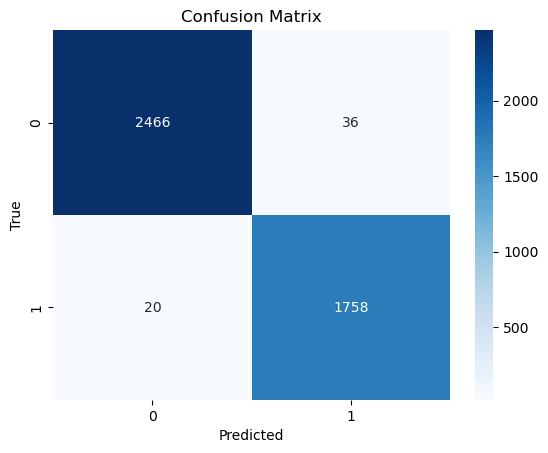

In [ ]:
# Confustion matrix for BASE
confusion_matrix_show(y_val_gender, predicted_gender)

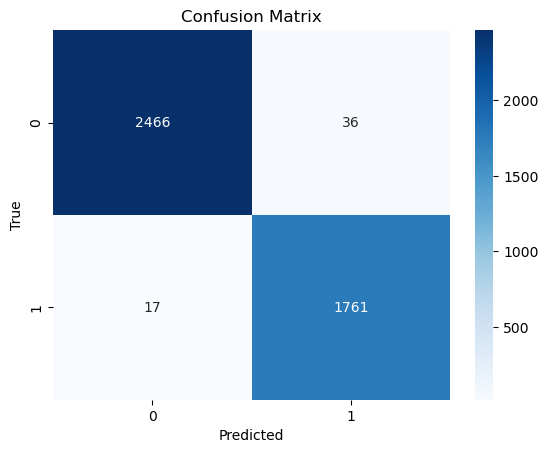

In [ ]:
# Confustion matrix for RESAMPLED
confusion_matrix_show(y_val_gender, predicted_gender_re)

In [ ]:
# Turn the predictions into a dataframe
df_full = pd.DataFrame({'True': y_val, 'Predicted': predicted_age_full})
df_full = mapping_tool(df_full)

df_base = pd.DataFrame({'True': y_val, 'Predicted': predicted_age})
df_base = mapping_tool(df_base)

df_full_re = pd.DataFrame({'True': y_val, 'Predicted': predicted_age_full_re})
df_full_re = mapping_tool(df_full_re)

df_re = pd.DataFrame({'True': y_val, 'Predicted': predicted_age_re})
df_re = mapping_tool(df_re)

C:\Users\Mikolaj Baranski\AppData\Local\Temp\ipykernel_8600\1502468780.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = point_frequency.pivot('Predicted', 'True', 'Frequency')


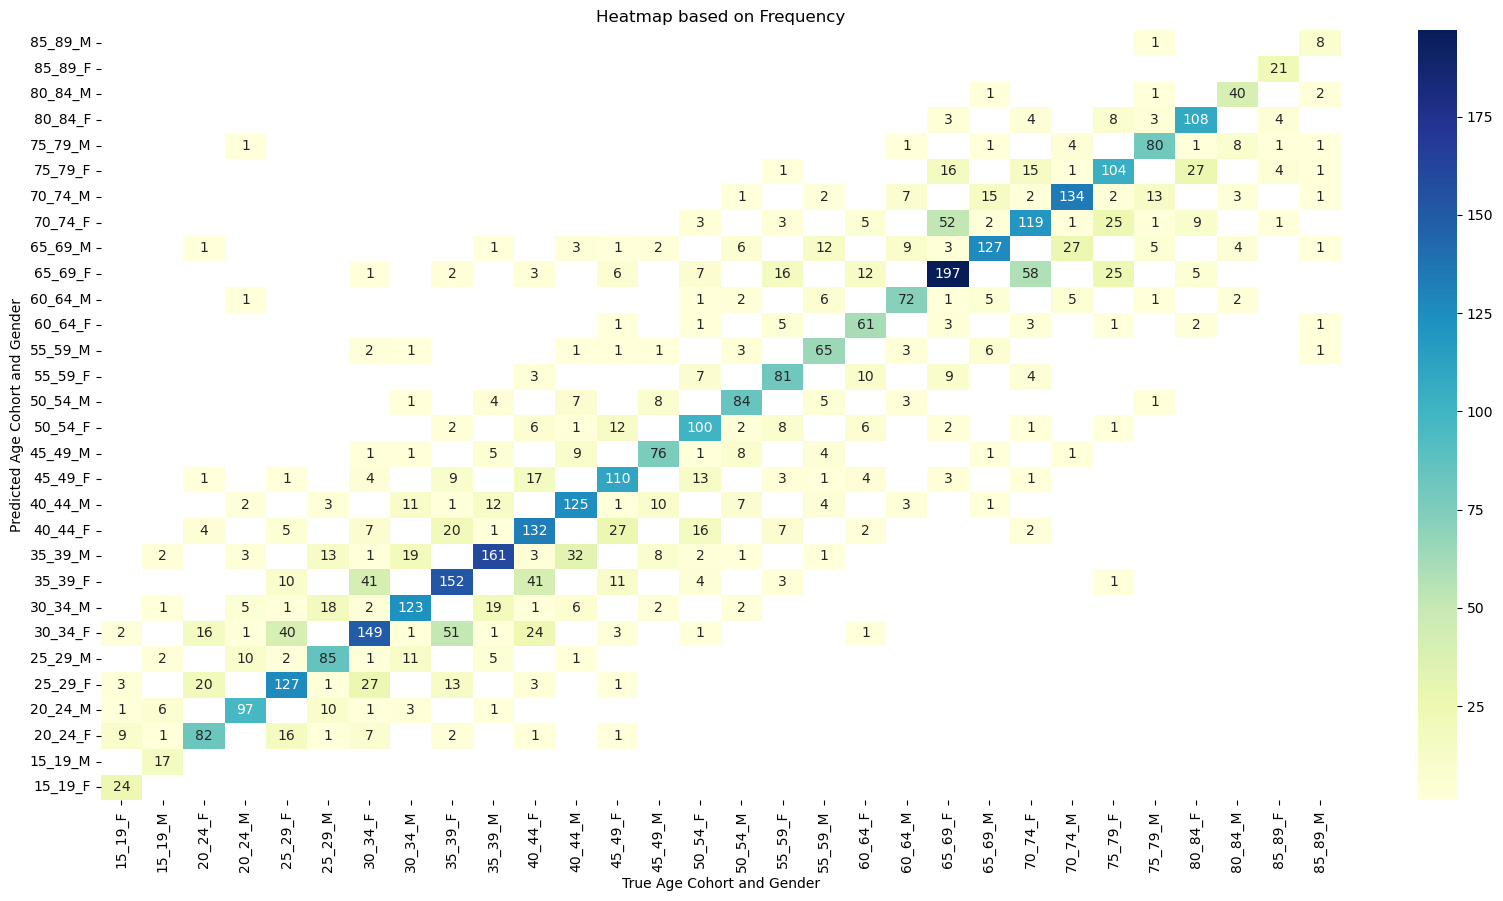

In [ ]:
# Create classification heatmap
graph_heat(df_full)

C:\Users\Mikolaj Baranski\AppData\Local\Temp\ipykernel_8600\1502468780.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = point_frequency.pivot('Predicted', 'True', 'Frequency')


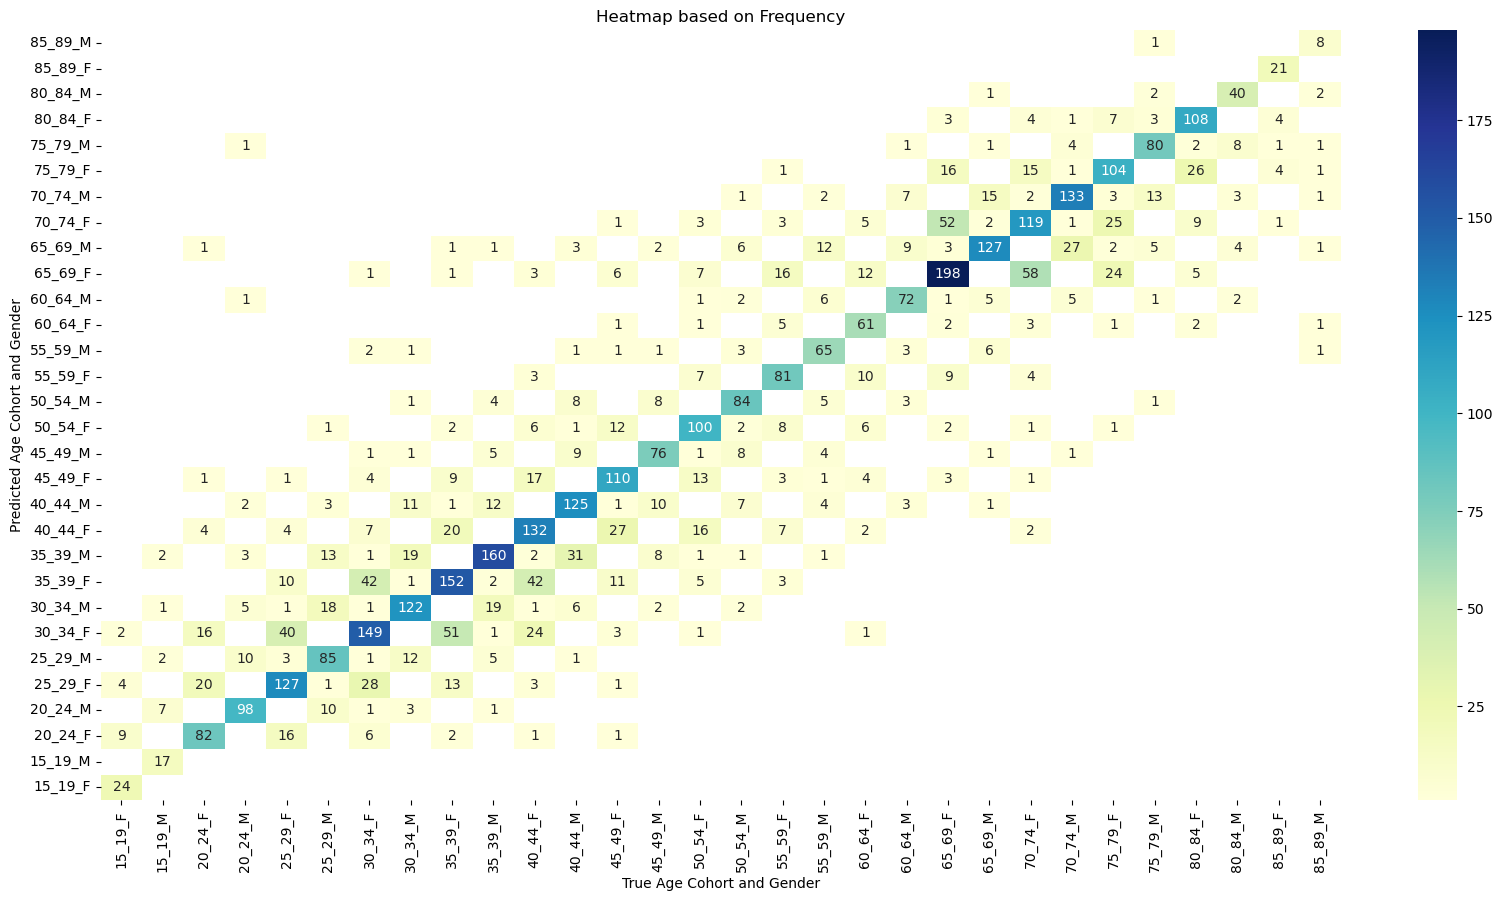

In [ ]:
# Create classification heatmap
graph_heat(df_base)

C:\Users\Mikolaj Baranski\AppData\Local\Temp\ipykernel_8600\1502468780.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = point_frequency.pivot('Predicted', 'True', 'Frequency')


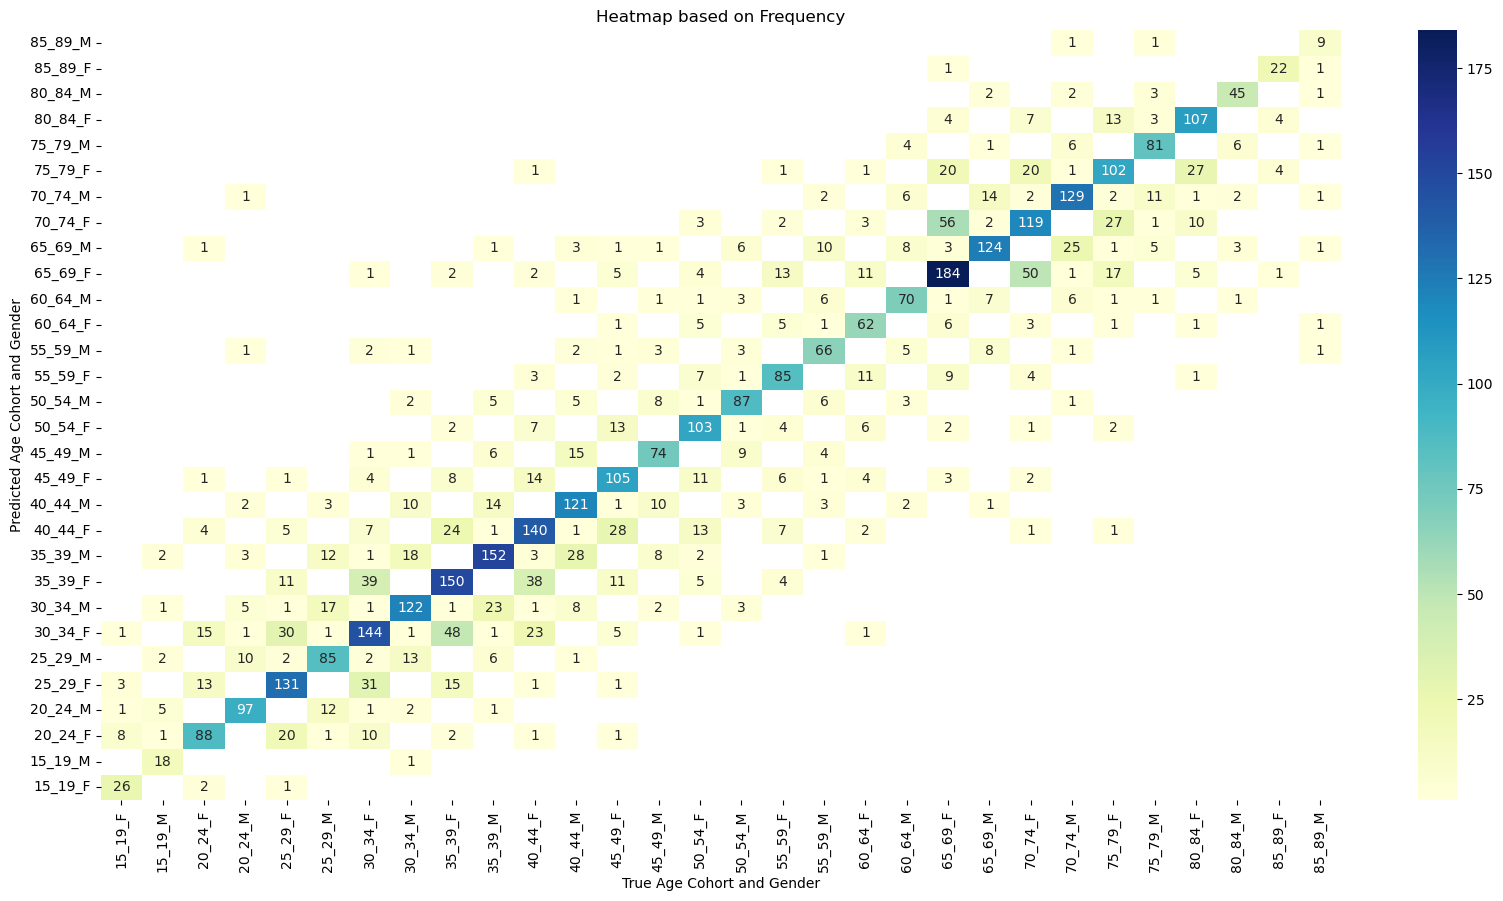

In [ ]:
# Create classification heatmap
graph_heat(df_full_re)

C:\Users\Mikolaj Baranski\AppData\Local\Temp\ipykernel_8600\1502468780.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = point_frequency.pivot('Predicted', 'True', 'Frequency')


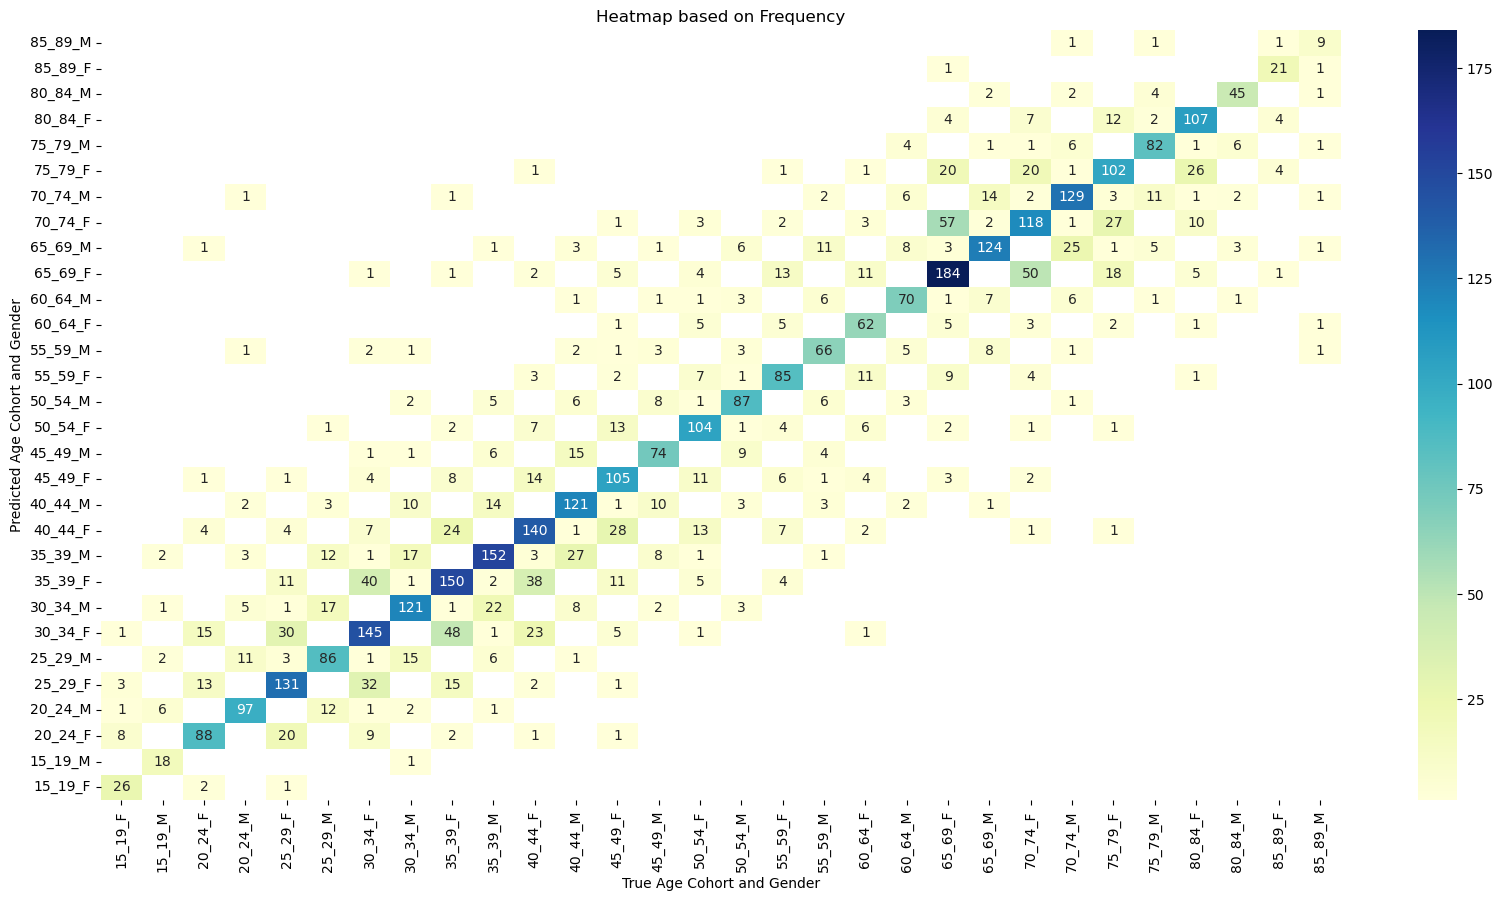

In [ ]:
# Create classification heatmap
graph_heat(df_re)

#### Cross validation dataset

In [ ]:
# Generate predictions on dataset FULL CROSS
predicted_age_full_cross = svm_full.predict(X_val_cross)

In [ ]:
# Generate predictions on dataset BASE CROSS
predicted_gender_cross, predicted_age_cross = get_SVM_preds(X_val_cross,svm_gender,svm_female_age,svm_male_age)

In [ ]:
# Generate predictions on dataset FULL CROSS
predicted_age_full_cross_re = svm_full_re.predict(X_val_cross)

In [ ]:
# Generate predictions on dataset RESAMPLED CROSS
predicted_gender_cross_re, predicted_age_cross_re = get_SVM_preds(X_val_cross,svm_gender_re,svm_female_age_re,svm_male_age_re)

In [ ]:
# Print classification report FULL CROSS
print(classification_report(y_val_cross, predicted_age_full_cross))

              precision    recall  f1-score   support

           0       0.50      0.01      0.01       170
           1       0.00      0.00      0.00       328
           2       0.22      0.20      0.21       561
           3       0.31      0.18      0.23       843
           4       0.17      0.11      0.13       744
           5       0.23      0.14      0.18      1059
           6       0.19      0.21      0.20      1005
           7       0.18      0.13      0.15      1185
           8       0.14      0.14      0.14      1021
           9       0.13      0.25      0.17      1187
          10       0.14      0.11      0.12      1147
          11       0.16      0.14      0.15      1331
          12       0.17      0.10      0.12      1476
          13       0.15      0.07      0.10      1649
          14       0.22      0.06      0.10      1621
          15       0.19      0.08      0.12      1841
          16       0.13      0.01      0.02      1623
          17       0.15    

C:\Users\Mikolaj Baranski\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mikolaj Baranski\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mikolaj Baranski\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print classification report BASE CROSS
print(classification_report(y_val_cross, predicted_age_cross))

              precision    recall  f1-score   support

           0       0.33      0.01      0.01       170
           1       0.00      0.00      0.00       328
           2       0.24      0.20      0.22       561
           3       0.30      0.19      0.23       843
           4       0.17      0.10      0.13       744
           5       0.22      0.15      0.18      1059
           6       0.19      0.20      0.20      1005
           7       0.18      0.13      0.15      1185
           8       0.14      0.14      0.14      1021
           9       0.13      0.25      0.17      1187
          10       0.14      0.11      0.12      1147
          11       0.17      0.14      0.15      1331
          12       0.17      0.10      0.13      1476
          13       0.14      0.07      0.10      1649
          14       0.22      0.06      0.10      1621
          15       0.19      0.08      0.12      1841
          16       0.13      0.01      0.02      1623
          17       0.15    

C:\Users\Mikolaj Baranski\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mikolaj Baranski\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mikolaj Baranski\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print classification report FULL RESAMPLED CROSS
print(classification_report(y_val_cross, predicted_age_full_cross_re))

              precision    recall  f1-score   support

           0       0.40      0.01      0.02       170
           1       0.16      0.01      0.02       328
           2       0.22      0.19      0.20       561
           3       0.31      0.20      0.24       843
           4       0.16      0.10      0.13       744
           5       0.20      0.15      0.17      1059
           6       0.18      0.20      0.19      1005
           7       0.17      0.12      0.14      1185
           8       0.15      0.14      0.14      1021
           9       0.12      0.23      0.16      1187
          10       0.15      0.11      0.13      1147
          11       0.17      0.15      0.16      1331
          12       0.17      0.11      0.13      1476
          13       0.14      0.07      0.09      1649
          14       0.21      0.07      0.10      1621
          15       0.19      0.09      0.12      1841
          16       0.16      0.01      0.03      1623
          17       0.14    

In [ ]:
# Print classification report RESAMPLED CROSS
print(classification_report(y_val_cross, predicted_age_cross_re))

              precision    recall  f1-score   support

           0       0.40      0.01      0.02       170
           1       0.20      0.01      0.02       328
           2       0.23      0.19      0.21       561
           3       0.31      0.21      0.25       843
           4       0.16      0.10      0.13       744
           5       0.19      0.15      0.17      1059
           6       0.18      0.20      0.19      1005
           7       0.17      0.12      0.14      1185
           8       0.15      0.15      0.15      1021
           9       0.12      0.23      0.16      1187
          10       0.14      0.10      0.12      1147
          11       0.17      0.15      0.16      1331
          12       0.17      0.11      0.14      1476
          13       0.14      0.07      0.09      1649
          14       0.21      0.07      0.10      1621
          15       0.19      0.09      0.12      1841
          16       0.16      0.01      0.03      1623
          17       0.14    

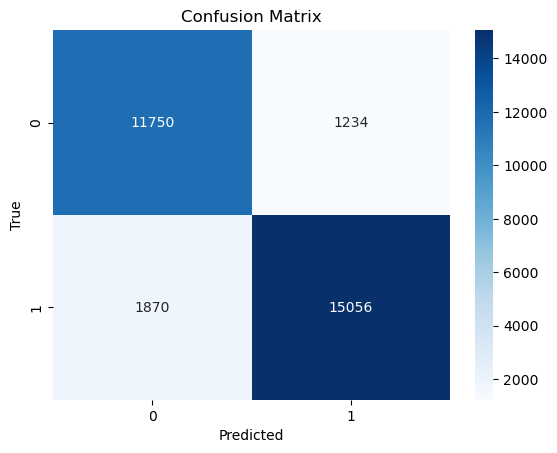

In [ ]:
# Confustion matrix for BASE CROSS
confusion_matrix_show(y_val_gender_cross, predicted_gender_cross)

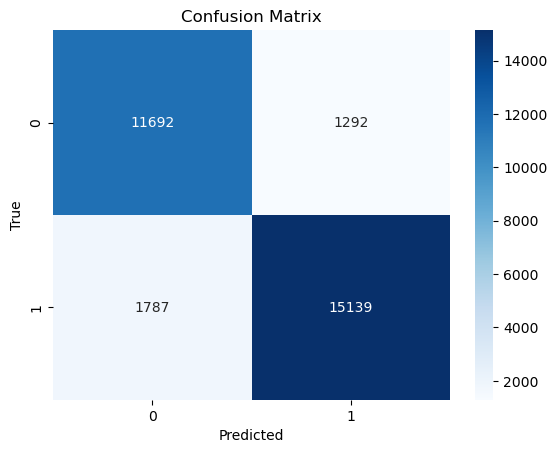

In [ ]:
# Confustion matrix for BASE
confusion_matrix_show(y_val_gender_cross, predicted_gender_cross_re)

In [ ]:
# Turn the predictions into a dataframe
df_cross_full = pd.DataFrame({'True': y_val_cross, 'Predicted': predicted_age_full_cross})
df_cross_full = mapping_tool(df_cross_full)

df_cross = pd.DataFrame({'True': y_val_cross, 'Predicted': predicted_age_cross})
df_cross = mapping_tool(df_cross)

df_cross_full_re = pd.DataFrame({'True': y_val_cross, 'Predicted': predicted_age_full_cross_re})
df_cross_full_re = mapping_tool(df_cross_full_re)

df_cross_re = pd.DataFrame({'True': y_val_cross, 'Predicted': predicted_age_cross_re})
df_cross_re = mapping_tool(df_cross_re)

C:\Users\Mikolaj Baranski\AppData\Local\Temp\ipykernel_8600\1502468780.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = point_frequency.pivot('Predicted', 'True', 'Frequency')


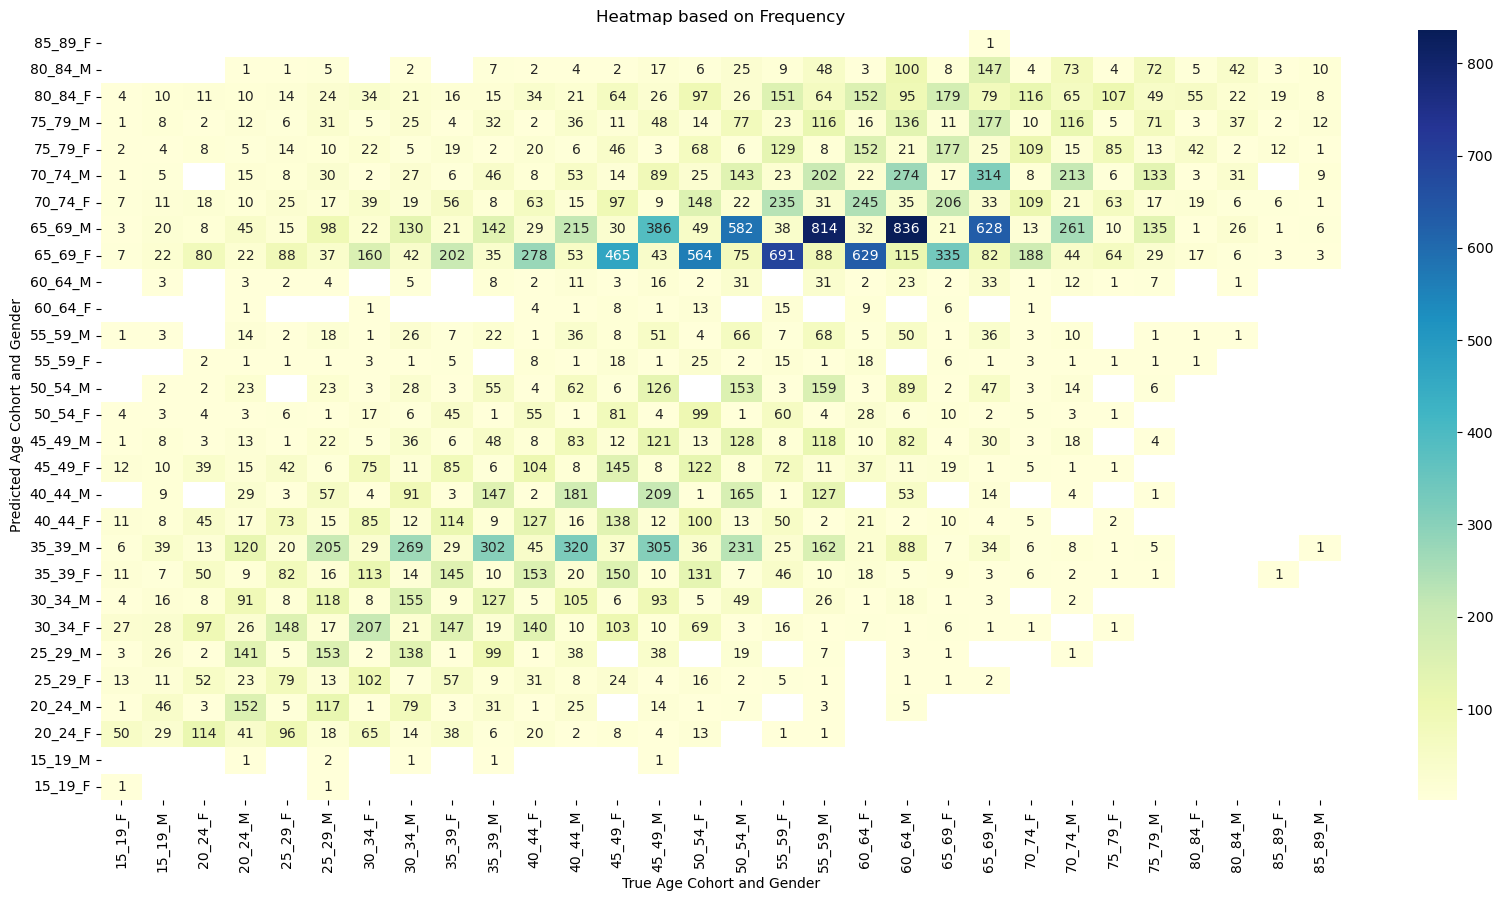

In [ ]:
# Create classification heatmap
graph_heat(df_cross_full)

C:\Users\Mikolaj Baranski\AppData\Local\Temp\ipykernel_15996\1502468780.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = point_frequency.pivot('Predicted', 'True', 'Frequency')


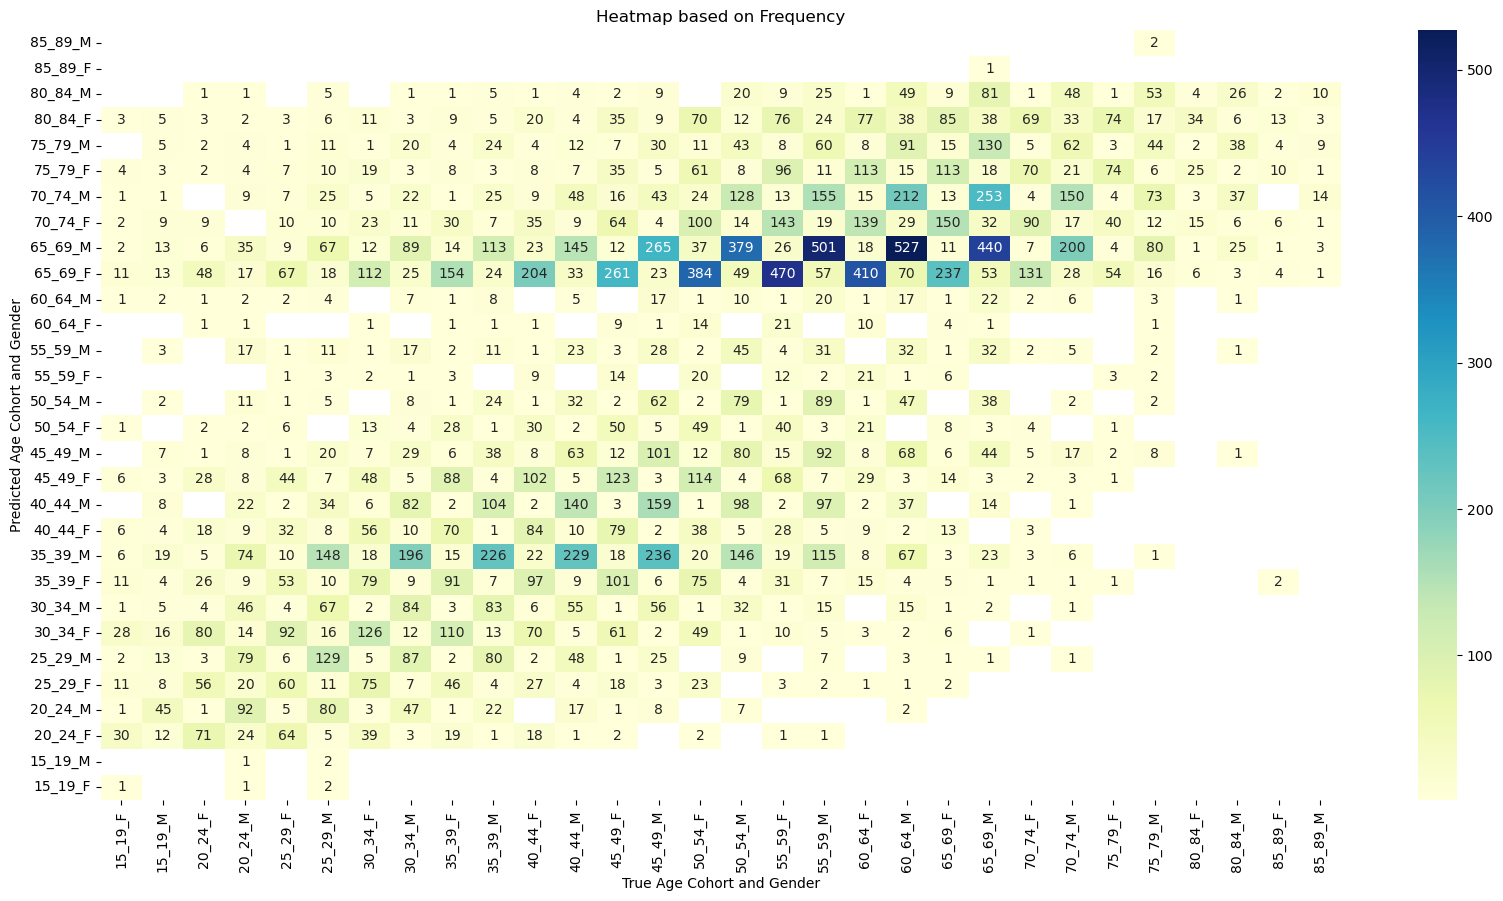

In [ ]:
# Create classification heatmap
graph_heat(df_cross)

C:\Users\Mikolaj Baranski\AppData\Local\Temp\ipykernel_15996\1502468780.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = point_frequency.pivot('Predicted', 'True', 'Frequency')


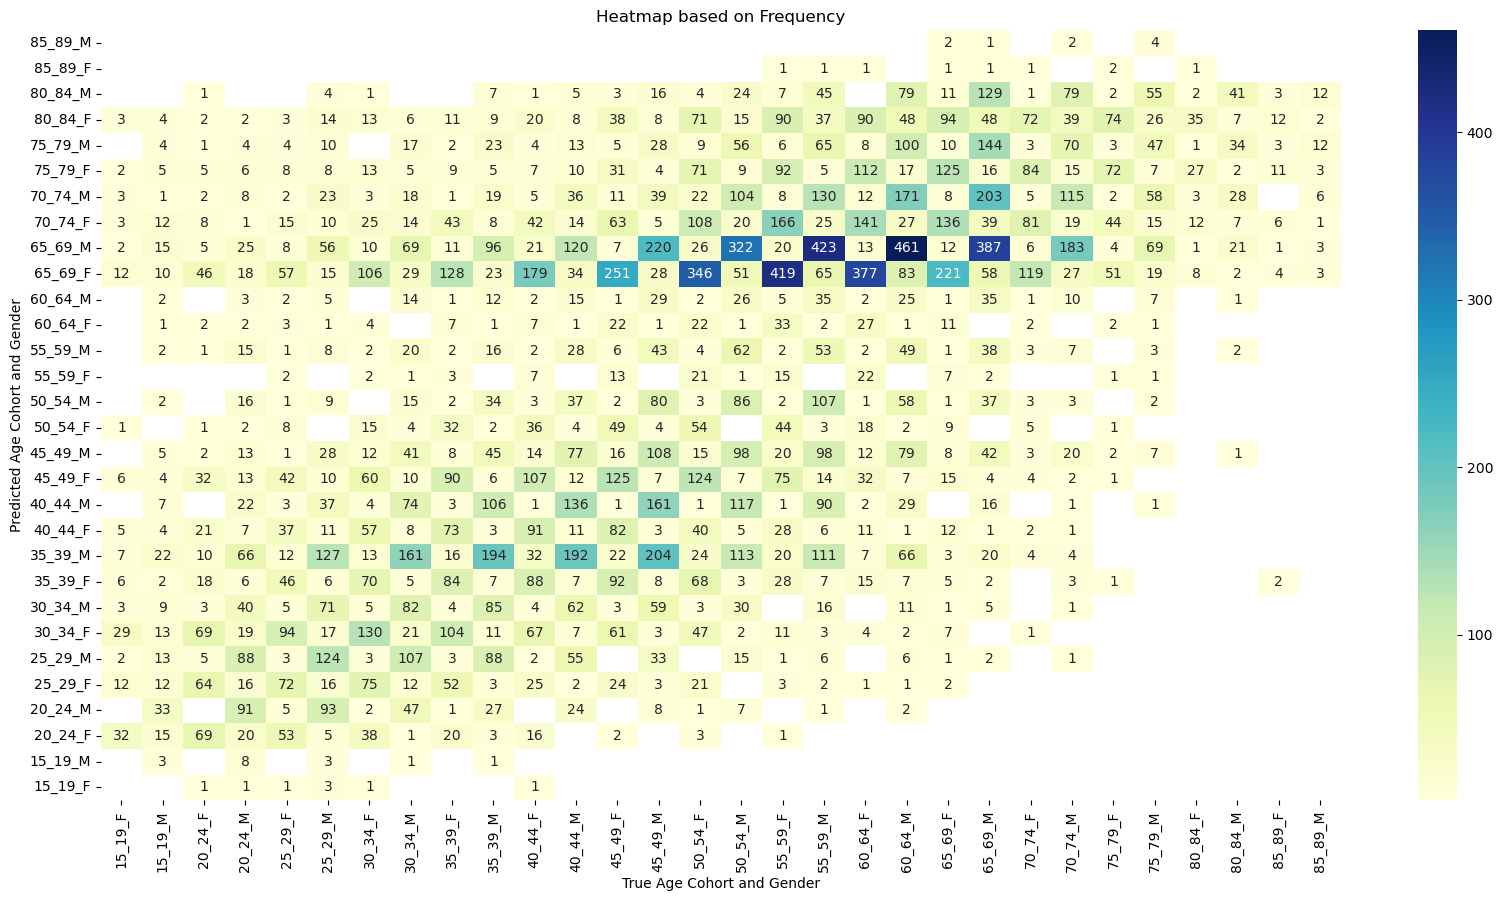

In [ ]:
# Create classification heatmap
graph_heat(df_cross_full_re)

C:\Users\Mikolaj Baranski\AppData\Local\Temp\ipykernel_15996\1502468780.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = point_frequency.pivot('Predicted', 'True', 'Frequency')


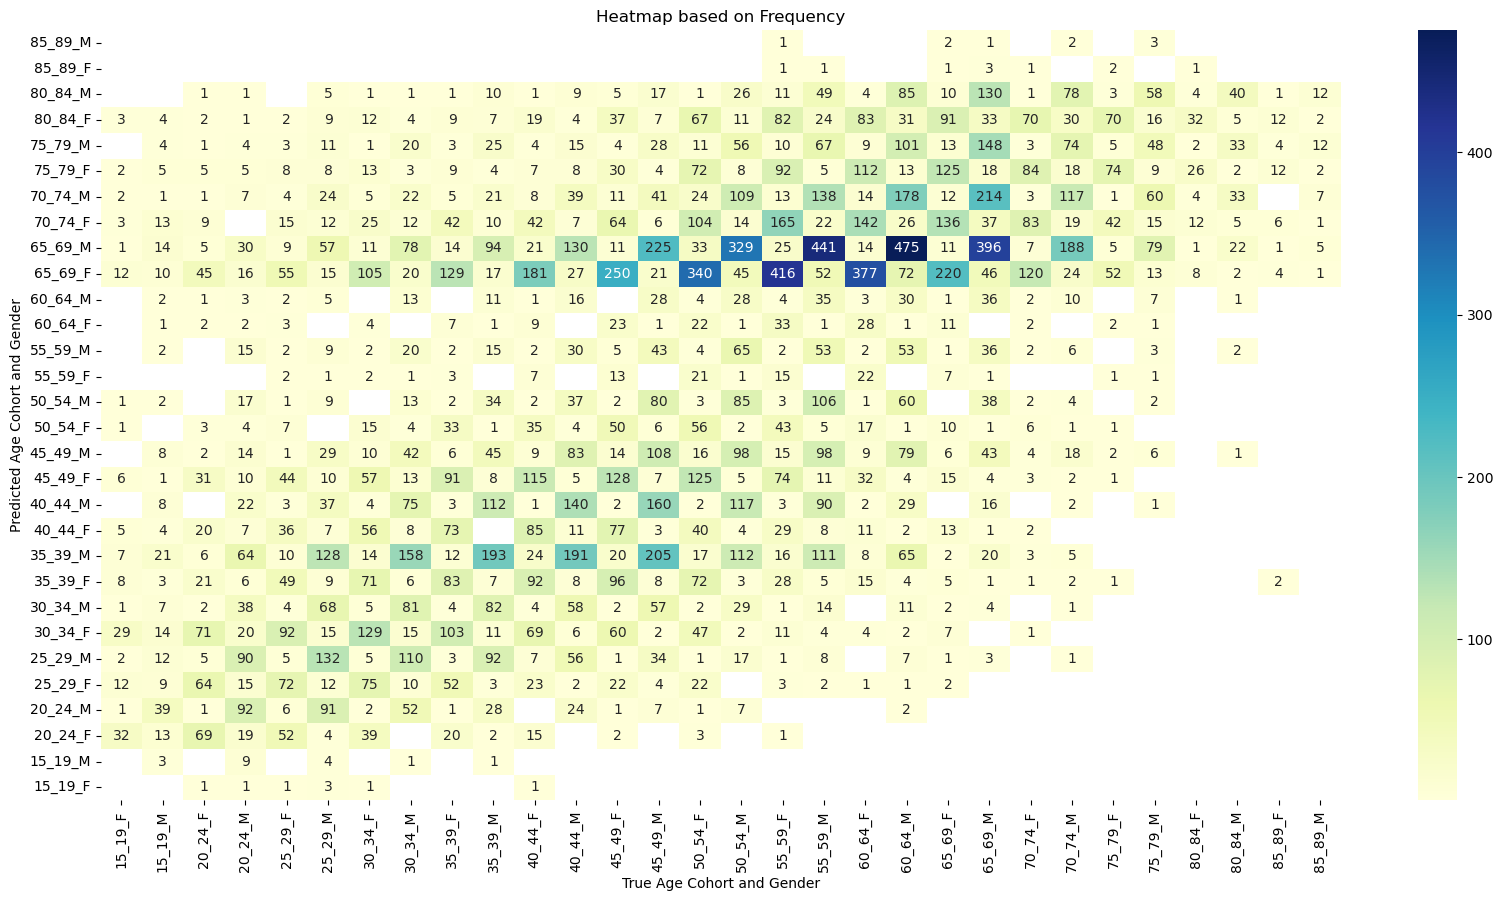

In [ ]:
# Create classification heatmap
graph_heat(df_cross_re)